# Bayesian Neural Networks

Neural networks are powerful aproximators. However, standard approaches for learning this aproximators does not take into account the inherent uncertainty we may have when fitting a model. 

In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import inferpy as inf
import tensorflow_probability as tfp


## Data

We use some fake data. As neural nets of even one hidden layer 
can be universal function aproximators, we can see if we can 
train a simple neural network to fit a noisy sinusoidal data, like this:
    

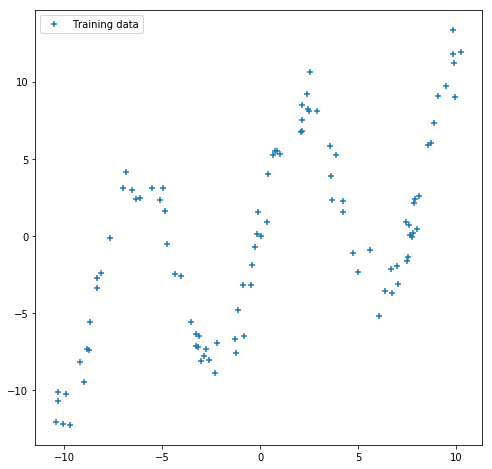

In [2]:
NSAMPLE = 100
x_train = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_train = np.float32(np.random.normal(size=(NSAMPLE,1),scale=1.0))
y_train = np.float32(np.sin(0.75*x_train)*7.0+x_train*0.5+r_train*1.0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.legend();

## Training a neural network

We employ a simple feedforward network with 20 hidden units to try to fit the data. 


In [3]:
NHIDDEN = 20

nnetwork = tf.keras.Sequential([
    tf.keras.layers.Dense(NHIDDEN, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1)
]) 

lossfunc = lambda y_out, y: tf.nn.l2_loss(y_out-y)

nnetwork.compile(tf.train.AdamOptimizer(0.01), lossfunc)
nnetwork.fit(x=x_train, y=y_train, epochs=1000)

Epoch 1/1000
100/100 [==============================] - 0s 2ms/sample - loss: 568.4292
Epoch 2/1000
100/100 [==============================] - 0s 119us/sample - loss: 491.9444
Epoch 3/1000
100/100 [==============================] - 0s 276us/sample - loss: 426.3571
Epoch 4/1000
100/100 [==============================] - 0s 253us/sample - loss: 399.9832
Epoch 5/1000
100/100 [==============================] - 0s 88us/sample - loss: 364.5782
Epoch 6/1000
100/100 [==============================] - 0s 182us/sample - loss: 365.8261
Epoch 7/1000
100/100 [==============================] - 0s 70us/sample - loss: 363.6429
Epoch 8/1000
100/100 [==============================] - 0s 125us/sample - loss: 360.3522
Epoch 9/1000
100/100 [==============================] - 0s 158us/sample - loss: 356.7377
Epoch 10/1000
100/100 [==============================] - 0s 166us/sample - loss: 346.9611
Epoch 11/1000
100/100 [==============================] - 0s 95us/sample - loss: 360.2084
Epoch 12/1000
100/100 [=

100/100 [==============================] - 0s 156us/sample - loss: 294.2410
Epoch 93/1000
100/100 [==============================] - 0s 72us/sample - loss: 295.5464
Epoch 94/1000
100/100 [==============================] - 0s 75us/sample - loss: 290.6517
Epoch 95/1000
100/100 [==============================] - 0s 77us/sample - loss: 299.8884
Epoch 96/1000
100/100 [==============================] - 0s 79us/sample - loss: 282.9824
Epoch 97/1000
100/100 [==============================] - 0s 83us/sample - loss: 290.6140
Epoch 98/1000
100/100 [==============================] - 0s 69us/sample - loss: 290.3444
Epoch 99/1000
100/100 [==============================] - 0s 88us/sample - loss: 290.9989
Epoch 100/1000
100/100 [==============================] - 0s 86us/sample - loss: 289.6357
Epoch 101/1000
100/100 [==============================] - 0s 65us/sample - loss: 298.5337
Epoch 102/1000
100/100 [==============================] - 0s 88us/sample - loss: 283.0190
Epoch 103/1000
100/100 [=======

100/100 [==============================] - 0s 58us/sample - loss: 255.9541
Epoch 184/1000
100/100 [==============================] - 0s 65us/sample - loss: 250.4445
Epoch 185/1000
100/100 [==============================] - 0s 64us/sample - loss: 253.6090
Epoch 186/1000
100/100 [==============================] - 0s 44us/sample - loss: 255.4150
Epoch 187/1000
100/100 [==============================] - 0s 67us/sample - loss: 241.2077
Epoch 188/1000
100/100 [==============================] - 0s 92us/sample - loss: 250.5764
Epoch 189/1000
100/100 [==============================] - 0s 70us/sample - loss: 249.4402
Epoch 190/1000
100/100 [==============================] - 0s 67us/sample - loss: 251.2757
Epoch 191/1000
100/100 [==============================] - 0s 79us/sample - loss: 243.2439
Epoch 192/1000
100/100 [==============================] - 0s 79us/sample - loss: 248.8469
Epoch 193/1000
100/100 [==============================] - 0s 74us/sample - loss: 229.3478
Epoch 194/1000
100/100 [=

100/100 [==============================] - 0s 92us/sample - loss: 183.5400
Epoch 275/1000
100/100 [==============================] - 0s 66us/sample - loss: 183.4689
Epoch 276/1000
100/100 [==============================] - 0s 77us/sample - loss: 180.7934
Epoch 277/1000
100/100 [==============================] - 0s 54us/sample - loss: 183.8320
Epoch 278/1000
100/100 [==============================] - 0s 65us/sample - loss: 169.8004
Epoch 279/1000
100/100 [==============================] - ETA: 0s - loss: 242.369 - 0s 62us/sample - loss: 181.6546
Epoch 280/1000
100/100 [==============================] - 0s 70us/sample - loss: 174.7812
Epoch 281/1000
100/100 [==============================] - 0s 65us/sample - loss: 173.8625
Epoch 282/1000
100/100 [==============================] - 0s 63us/sample - loss: 167.0729
Epoch 283/1000
100/100 [==============================] - 0s 63us/sample - loss: 182.3651
Epoch 284/1000
100/100 [==============================] - 0s 51us/sample - loss: 164.5383

100/100 [==============================] - 0s 57us/sample - loss: 125.3583
Epoch 365/1000
100/100 [==============================] - 0s 72us/sample - loss: 130.1117
Epoch 366/1000
100/100 [==============================] - 0s 49us/sample - loss: 130.4409
Epoch 367/1000
100/100 [==============================] - 0s 72us/sample - loss: 126.2436
Epoch 368/1000
100/100 [==============================] - 0s 54us/sample - loss: 128.4143
Epoch 369/1000
100/100 [==============================] - 0s 67us/sample - loss: 125.8916
Epoch 370/1000
100/100 [==============================] - 0s 50us/sample - loss: 118.5130
Epoch 371/1000
100/100 [==============================] - 0s 55us/sample - loss: 118.9068
Epoch 372/1000
100/100 [==============================] - 0s 50us/sample - loss: 118.7255
Epoch 373/1000
100/100 [==============================] - 0s 87us/sample - loss: 119.9374
Epoch 374/1000
100/100 [==============================] - 0s 61us/sample - loss: 113.9208
Epoch 375/1000
100/100 [=

100/100 [==============================] - 0s 104us/sample - loss: 40.4509
Epoch 456/1000
100/100 [==============================] - 0s 48us/sample - loss: 41.2542
Epoch 457/1000
100/100 [==============================] - 0s 95us/sample - loss: 36.8322
Epoch 458/1000
100/100 [==============================] - 0s 52us/sample - loss: 40.2748
Epoch 459/1000
100/100 [==============================] - 0s 79us/sample - loss: 39.5731
Epoch 460/1000
100/100 [==============================] - 0s 56us/sample - loss: 38.0546
Epoch 461/1000
100/100 [==============================] - 0s 104us/sample - loss: 38.2345
Epoch 462/1000
100/100 [==============================] - 0s 54us/sample - loss: 38.0446
Epoch 463/1000
100/100 [==============================] - 0s 92us/sample - loss: 36.7839
Epoch 464/1000
100/100 [==============================] - 0s 52us/sample - loss: 36.9070
Epoch 465/1000
100/100 [==============================] - 0s 99us/sample - loss: 36.5862
Epoch 466/1000
100/100 [==========

100/100 [==============================] - 0s 69us/sample - loss: 20.9840
Epoch 547/1000
100/100 [==============================] - 0s 59us/sample - loss: 20.7253
Epoch 548/1000
100/100 [==============================] - 0s 73us/sample - loss: 20.2704
Epoch 549/1000
100/100 [==============================] - 0s 56us/sample - loss: 20.7854
Epoch 550/1000
100/100 [==============================] - 0s 95us/sample - loss: 19.4629
Epoch 551/1000
100/100 [==============================] - 0s 60us/sample - loss: 20.2286
Epoch 552/1000
100/100 [==============================] - 0s 99us/sample - loss: 20.5227
Epoch 553/1000
100/100 [==============================] - 0s 49us/sample - loss: 19.7976
Epoch 554/1000
100/100 [==============================] - 0s 82us/sample - loss: 20.0890
Epoch 555/1000
100/100 [==============================] - 0s 53us/sample - loss: 19.5588
Epoch 556/1000
100/100 [==============================] - 0s 88us/sample - loss: 19.5982
Epoch 557/1000
100/100 [============

100/100 [==============================] - 0s 73us/sample - loss: 17.7214
Epoch 639/1000
100/100 [==============================] - 0s 102us/sample - loss: 17.2944
Epoch 640/1000
100/100 [==============================] - 0s 53us/sample - loss: 18.0736
Epoch 641/1000
100/100 [==============================] - 0s 82us/sample - loss: 17.6868
Epoch 642/1000
100/100 [==============================] - 0s 56us/sample - loss: 17.6902
Epoch 643/1000
100/100 [==============================] - 0s 85us/sample - loss: 17.7050
Epoch 644/1000
100/100 [==============================] - 0s 65us/sample - loss: 17.0873
Epoch 645/1000
100/100 [==============================] - 0s 81us/sample - loss: 17.5027
Epoch 646/1000
100/100 [==============================] - 0s 54us/sample - loss: 17.1977
Epoch 647/1000
100/100 [==============================] - 0s 90us/sample - loss: 17.4070
Epoch 648/1000
100/100 [==============================] - 0s 55us/sample - loss: 17.1828
Epoch 649/1000
100/100 [===========

100/100 [==============================] - 0s 51us/sample - loss: 17.4619
Epoch 731/1000
100/100 [==============================] - 0s 99us/sample - loss: 15.8713
Epoch 732/1000
100/100 [==============================] - 0s 70us/sample - loss: 18.1533
Epoch 733/1000
100/100 [==============================] - 0s 50us/sample - loss: 17.5346
Epoch 734/1000
100/100 [==============================] - 0s 72us/sample - loss: 17.3331
Epoch 735/1000
100/100 [==============================] - 0s 56us/sample - loss: 17.2133
Epoch 736/1000
100/100 [==============================] - 0s 50us/sample - loss: 16.2627
Epoch 737/1000
100/100 [==============================] - 0s 95us/sample - loss: 16.5845
Epoch 738/1000
100/100 [==============================] - 0s 88us/sample - loss: 16.8911
Epoch 739/1000
100/100 [==============================] - 0s 71us/sample - loss: 16.7579
Epoch 740/1000
100/100 [==============================] - 0s 106us/sample - loss: 17.2080
Epoch 741/1000
100/100 [===========

100/100 [==============================] - 0s 81us/sample - loss: 15.6553
Epoch 822/1000
100/100 [==============================] - 0s 98us/sample - loss: 16.1121
Epoch 823/1000
100/100 [==============================] - 0s 60us/sample - loss: 15.4862
Epoch 824/1000
100/100 [==============================] - 0s 111us/sample - loss: 15.9309
Epoch 825/1000
100/100 [==============================] - 0s 80us/sample - loss: 16.8424
Epoch 826/1000
100/100 [==============================] - 0s 90us/sample - loss: 16.1344
Epoch 827/1000
100/100 [==============================] - 0s 54us/sample - loss: 16.5852
Epoch 828/1000
100/100 [==============================] - 0s 110us/sample - loss: 16.6919
Epoch 829/1000
100/100 [==============================] - 0s 185us/sample - loss: 17.2438
Epoch 830/1000
100/100 [==============================] - 0s 173us/sample - loss: 16.5476
Epoch 831/1000
100/100 [==============================] - 0s 114us/sample - loss: 16.9315
Epoch 832/1000
100/100 [=======

100/100 [==============================] - 0s 173us/sample - loss: 16.1843
Epoch 913/1000
100/100 [==============================] - 0s 93us/sample - loss: 17.6008
Epoch 914/1000
100/100 [==============================] - 0s 96us/sample - loss: 15.2302
Epoch 915/1000
100/100 [==============================] - 0s 59us/sample - loss: 15.9779
Epoch 916/1000
100/100 [==============================] - 0s 64us/sample - loss: 17.5510
Epoch 917/1000
100/100 [==============================] - 0s 93us/sample - loss: 16.7472
Epoch 918/1000
100/100 [==============================] - 0s 53us/sample - loss: 17.0852
Epoch 919/1000
100/100 [==============================] - 0s 73us/sample - loss: 16.6998
Epoch 920/1000
100/100 [==============================] - 0s 43us/sample - loss: 16.9339
Epoch 921/1000
100/100 [==============================] - 0s 61us/sample - loss: 16.8321
Epoch 922/1000
100/100 [==============================] - 0s 60us/sample - loss: 16.4658
Epoch 923/1000
100/100 [===========

We see that the neural network can fit this sinusoidal data quite well, as expected. 

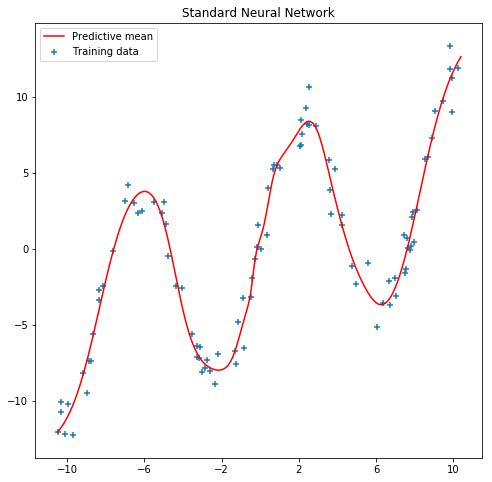

In [4]:
sess = tf.keras.backend.get_session()
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(nnetwork(x_test))

plt.figure(figsize=(8, 8))
plt.plot(x_test, y_test, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xticks(np.arange(-10., 10.5, 4))
plt.title('Standard Neural Network')
plt.legend();

However this model is unable to capture the uncertainty in the model. For example, when making predictions about a single point (e.g. around x=2.0) we can see we do not account aobut the inherent noise there is in this predictions. In next section, we will what happen when we introduce a Bayesian approach using Inferpy. 

## Bayesian Learning of Neural Networks

[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a distribution over variables that are consistent with the observed data.

In Bayesian learning, the weights of the network are `random variables`. The output of the nework is another `random variable`. And the random variable of the output is the one that implicitlyl defines the ``loss function``. So, when making Bayesian learning we do not define ``loss functions``, we do define ``random variables``. For more information you can check [this talk](https://www.cs.ox.ac.uk/people/yarin.gal/website/PDFs/2017_OReilly_talk.pdf) and this [paper](https://arxiv.org/abs/1908.03442).

In [Inferpy](https://inferpy.readthedocs.io), defining a Bayesian neural network is quite straightforward. First we 
define our neural network using ``inf.layers.Sequential`` and layers of class ``tfp.layers.DenseFlipout``. Second, the input `x` and output `y` are also define as random variables. More precisely, the output `y` is defined as a Gaussian random varible. The mean of the Gaussian is the output of the neural network.

In [5]:
@inf.probmodel
def model(NHIDDEN):

    with inf.datamodel():
        x = inf.Normal(loc = tf.zeros([1]), scale = 1.0, name="x")
        
        nnetwork = inf.layers.Sequential([
            tfp.layers.DenseFlipout(NHIDDEN, activation=tf.nn.tanh),
            tfp.layers.DenseFlipout(1)
        ]) 
        
        y = inf.Normal(loc = nnetwork(x) , scale= 1., name="y")

To perform Bayesian learning, we resort the scalable variational methods available in Inferpy, which require the definition of a `q` model. For details,see the documentation about [Inference in Inferpy](https://inferpy.readthedocs.io/projects/develop/en/develop/notes/guideinference.html). For a deeper theoretical despcription, read this [paper](https://arxiv.org/abs/1908.03442). In this case, the q variables approximating the NN are defined in a transparent way. For that reason we define an empty q model.

In [6]:
@inf.probmodel
def qmodel():
    pass


In [7]:
NHIDDEN=20

p = model(NHIDDEN)
q = qmodel()

VI = inf.inference.VI(q, optimizer = tf.train.AdamOptimizer(0.01), epochs=5000)

p.fit({"x": x_train, "y": y_train}, VI)


 0 epochs	 3848.40380859375....................
 200 epochs	 3139.6318359375....................
 400 epochs	 2526.8134765625....................
 600 epochs	 2179.938720703125....................
 800 epochs	 2139.319580078125....................
 1000 epochs	 2136.826171875....................
 1200 epochs	 2134.130126953125....................
 1400 epochs	 2133.23486328125....................
 1600 epochs	 2135.37744140625....................
 1800 epochs	 2133.60205078125....................
 2000 epochs	 2132.572265625....................
 2200 epochs	 2131.497802734375....................
 2400 epochs	 2131.830078125....................
 2600 epochs	 2130.97509765625....................
 2800 epochs	 2130.1396484375....................
 3000 epochs	 2130.180419921875....................
 3200 epochs	 2129.81396484375....................
 3400 epochs	 2129.61865234375....................
 3600 epochs	 2128.593505859375....................
 3800 epochs	 2129.256103515625.........

As can be seen in the nex figure, the output of our model is not deterministic. So, we can caputure the uncertainty in the data. See for example what happens now with the predictions at the point `x=2.0`. See also what happens with the uncertainty in out-of-range predictions.

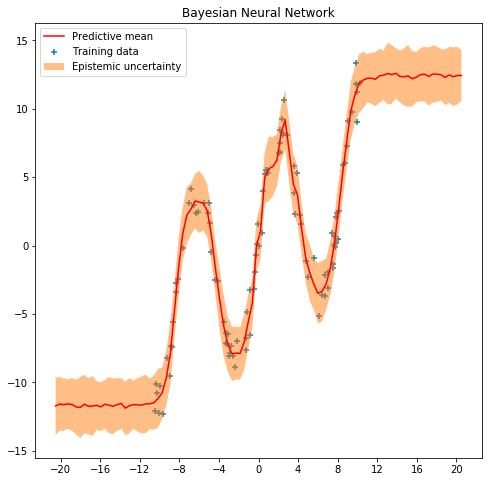

In [8]:
x_test = np.linspace(-20.5, 20.5, NSAMPLE).reshape(-1, 1)

plt.figure(figsize=(8, 8))

y_pred_list = []
for i in range(100):
    y_test = p.posterior_predictive(["y"], data = {"x": x_test}).sample()
    y_pred_list.append(y_test)

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian Neural Network')
plt.legend();